In [ ]:
!pip install tf-keras-vis tensorflow

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

C:\Users\rodam\anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Tensorflow recognized 0 GPUs


In [2]:
imagelabels = open("./data/imagenetlabels.txt", "r")
netlabels1 = imagelabels.readlines()
netlabels = dict()
count = 0
for line in netlabels1:
    if "{" in line:
        line = line.replace("{", "")
    elif "}" in line:
        line = line.replace("}", "")
    if "'" in line:
        line = line.replace("'", "")
    line = line.strip()[:-1]
    result = ''.join([i for i in line if not i.isdigit()])[2:]
    netlabels[count] = result
    count += 1

netlabels

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load images and convert to numpy array
images = []
num_images_jpg = 4
num_images_png = 1
cols = 5
rows = 1
for i in range(num_images_jpg):
    images.append(load_img('images/img' + str(i+1) + ".jpg", target_size=(224, 224)))

for i in range(num_images_png):
    images.append(load_img('images/img' + str(i+1) + ".png", target_size=(224, 224)))

nparrays = []
for img in images:
    nparrays.append(np.array(img))

images = np.asarray(nparrays)

# Prep for input into VGG16
X = preprocess_input(images)

In [5]:
from tensorflow.keras.applications.vgg16 import decode_predictions
predictions = model.predict(images)
predictions
labels = decode_predictions(predictions)


true_labels = []
accuracies = []
for i in range(len(labels)):
    name = labels[i][0][1]
    if "_" in name:
        name = name.replace("_", " ")
    true_labels.append(name)
    accuracies.append(labels[i][0][2])


classes = []
for label in true_labels:
    for key, value in netlabels.items():
        if label in value:
            classes.append(int(key))
            break
print(classes)

[296, 711, 1, 413, 24]


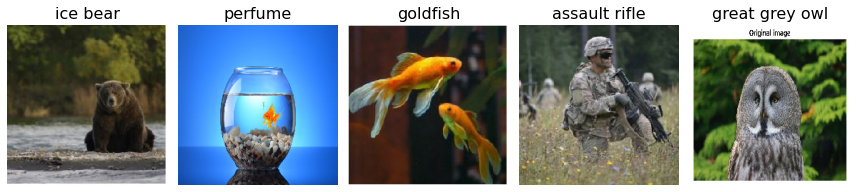

In [6]:
# Rendering
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))
for i, title in enumerate(true_labels):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [7]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Alternative replacement function
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [8]:
from tf_keras_vis.utils.scores import CategoricalScore

# Imagenet indices
score = CategoricalScore(classes)

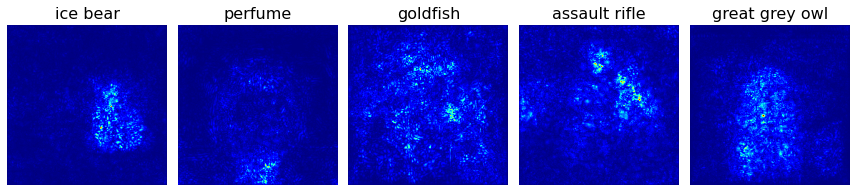

In [9]:
# Vanilla Saliency

#%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))
for i, title in enumerate(true_labels):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

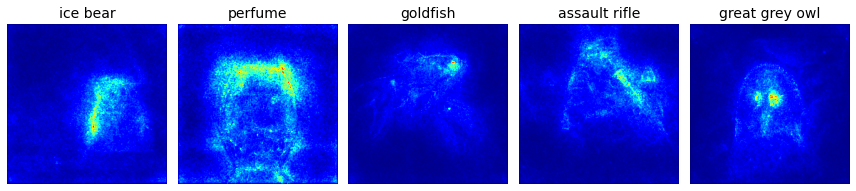

In [10]:
# SmoothGrad

#%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))
for i, title in enumerate(true_labels):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/smoothgrad.png')
plt.show()

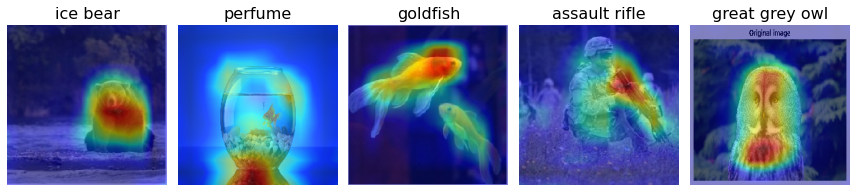

In [14]:
# GradCam++

#%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))
for i, title in enumerate(true_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/gradcam_plus_plus.png')
plt.show()

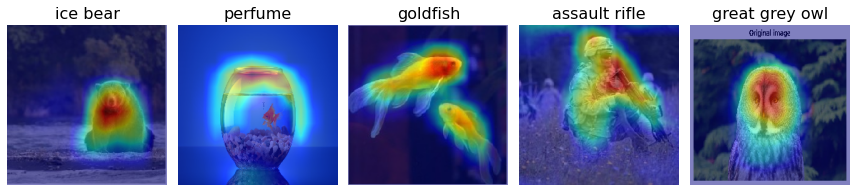

In [16]:
# Faster-ScoreCAM

#%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))
for i, title in enumerate(true_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()